## Python - A Crash Course By Example
## Simple Performance Optimizations
Dr. Victor Pankratius<br>
Massachusetts Institute of Technology<br>
http://www.victorpankratius.com

<hr>

## JobLib - Python Functions as Pipeline Jobs
https://joblib.readthedocs.io/en/latest/
<hr>

In [1]:
#%% JobLib    Code and text from https://pythonhosted.org/joblib/joblib/

##############
# Caching
#
# Useful for long-running calculations
#
#Transparent and fast disk-caching of output values; works for arbitrary 
#Python objects, including very large numpy arrays. Joblib can save computation 
#results to disk and rerun computations only if necessary.
#
#The Memory class defines a context for lazy evaluation of function, 
#by storing the results to the disk, and not rerunning the function twice 
#for the same arguments.

In [2]:
# !pip install joblib #uncomment and run this line if not joblib is not installed

In [3]:
from joblib import Memory
memory = Memory(cachedir='/tmp/joblib', verbose=0)

# decorate the function to be cached
@memory.cache
def f(x): 
    print ('Running f(%s)' % (x) )
    return x*x

print( f(3) )
#> Running f(3)
#  9

9


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/joblib'", use "location='/tmp/joblib'" instead.
  


In [4]:
#When we call this function twice with the same argument, it does not get 
#executed the second time, and the output gets loaded from the cache (pickle file)
print( f(3) )
#> 9


9


In [5]:
#However, when we call it a third time, with a different argument, the 
#output gets recomputed:
print (f(2) )
#> 4

4


## Numba -  Just-In-Time (JIT) Compilation
http://numba.pydata.org <br>
http://numba.pydata.org/numba-doc/latest/user/talks.html <br>
http://numba.pydata.org/numba-doc/latest/user/5minguide.html
<hr>

In [6]:
#%%
# Numba  - Code and text from http://numba.pydata.org
#
#Numba gives you the power to speed up your applications with high performance 
#functions written directly in Python.
#
#Numba generates optimized machine code from pure Python code using the LLVM 
#compiler infrastructure. With a few simple annotations, array-oriented and 
#math-heavy Python code can be just-in-time optimized to performance similar 
#as C, C++ and Fortran, without having to switch languages or Python 
#interpreters.
#
#Numba's main features are:
# * on-the-fly code generation (at import time or runtime, at the user's preference) 
# * native code generation for the CPU (default) and GPU hardware
# * integration with the Python scientific software stack (thanks to Numpy)
#
# see also 
#  http://continuum.io/blog/numba_performance
#  http://continuum.io/blog/tags/Numba 
#  http://en.wikipedia.org/wiki/Numba

In [7]:
# !pip install numba #uncomment and run this if not installed

In [8]:
##############
# JIT  - Just-In-Time compilation

from numba import jit
from numpy import arange

import time

In [9]:
# jit decorator tells Numba to compile this function. Uncomment to see 
# performance difference.
# The argument types will be inferred by Numba when function is called.
@jit
def sum2d(arr):
    M, N = arr.shape
    result = 0.0
    for i in range(M):
        for j in range(N):
            result += arr[i,j]
    return result

In [10]:
a = arange(9000000).reshape(3000,3000)

start = time.time()
print(sum2d(a))
#> 4.04999955e+13
end = time.time()

40499995500000.0


In [11]:
print ("%s sec" % (end - start))
#> 0.119330883026 sec    (with JIT on my laptop)
#> 1.76066303253 sec     (without JIT on my laptop)

0.1413860321044922 sec


In [12]:
##############
#Vectorization
#
#Using vectorize(), you write your function as operating over input scalars, 
#rather than arrays. Numba will generate the surrounding loop (or kernel) 
#allowing efficient iteration over the actual inputs.

from numba import vectorize, float64

In [13]:
@vectorize([float64(float64, float64)])
def f(x, y):
    return x + y
    
a = arange(10)

In [14]:
print (a)
#> [0 1 2 3 4 5 6 7 8 9]

[0 1 2 3 4 5 6 7 8 9]


In [15]:
print (f(a,a))
#> [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.]

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


In [16]:
#While vectorize() allows you to write ufuncs that work on one element at 
#a time, the guvectorize() decorator takes the concept one step further 
#and allows you to write ufuncs that will work on an arbitrary number of 
#elements of input arrays, and take and return arrays of differing dimensions. 
#The typical example is a running median or a convolution filter. Contrary 
#to vectorize() functions, guvectorize() functions don't return their result 
#value: their take it as an array argument, which must be filled in by the 
#function. This is because the array is actually allocated by NumPy's dispatch 
#mechanism, which calls into the Numba-generated code.
#
#The underlying Python function simply adds a given scalar (y) to all elements 
#of a 1-dimension array. What's more interesting is the declaration. There are 
#two things there:
#
#* the declaration of input and output layouts, in symbolic form: (n),()->(n) tells 
#  NumPy that the function takes a n-element one-dimension array, a scalar 
#  (symbolically denoted by the empty tuple ()) and returns a n-element 
#  one-dimension array;
#
#* the list of supported concrete signatures as in @vectorize; here we only 
#  support int64 arrays.

from numba import guvectorize, int64

In [17]:
@guvectorize([(int64[:], int64[:], int64[:])], '(n),()->(n)')
def g(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y[0]
        
a = arange(6).reshape(2, 3)

In [18]:
print (g(a, 10))
#> [[10 11 12]
#   [13 14 15]]

[[10 11 12]
 [13 14 15]]


###  Mandelbrot set with Numba JIT optimization
<hr>

In [19]:
import numpy as np
import pylab

from numba import jit
import time

In [20]:
@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    c = complex(x,y)
    z = 0j
    for i in range(max_iters):
        z = z*z + c
        if z.real * z.real + z.imag * z.imag >= 4:
            return 255 * i // max_iters

    return 255

In [21]:
@jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((700, 1400), dtype=np.uint8)

0.22002601623535156 sec


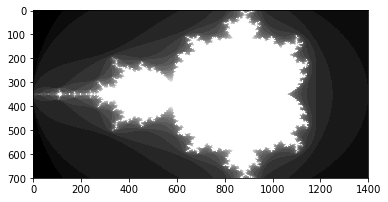

In [22]:
start = time.time()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
end = time.time()
print ("%s sec" % (end - start))

#> 0.245831012726 sec   (with JIT on, on my laptop)
#> 4.82949304581 sec    (with JIT off, on my laptop)

pylab.imshow(image)
pylab.gray()
pylab.show()

#### Other references
https://cython.org C-Extensions for Python <br>
https://pypy.org